In [259]:
import pandas as pd
import numpy as np
from queue import PriorityQueue
from numpy import inf
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist

from mpl_toolkits.mplot3d import Axes3D

import random

%matplotlib notebook

# All Data
alldata = pd.read_csv('/home/lucasperea/Documents/1.A_Dijkstra/Data/EDI_Separatrices.csv')
pos_df = alldata.loc[alldata['SepMinValue'] > 0]

In [260]:
class Graph:

    def __init__(self, num_of_vertices, dist_mat):
        self.v = num_of_vertices
        self.edges = dist_mat
        self.visited = []
        
    def add_edge(self, u, v, weight):
        self.edges[u][v] = weight
        self.edges[v][u] = weight
        
    def dijkstra(self, start_vertex, target, parents):
        
        # Dictionary with keys = vertices and values = weights of the vertices (set as infinity at the start)
        D = {v:float('inf') for v in range(self.v)}
        D[start_vertex] = 0

        pq = PriorityQueue()
        pq.put((0, start_vertex))

        while not pq.empty():
            (dist, current_vertex) = pq.get()
            if current_vertex == target:
                print('Target vertex: ' + str(target) + ' reached')
                break
            else:
                
                self.visited.append(current_vertex)
                

                # Loop for every vertex of the net
                for neighbor in range(self.v):
                    if self.edges[current_vertex][neighbor] != -1:
                        distance = self.edges[current_vertex][neighbor]
                        if neighbor not in self.visited:
                            old_cost = D[neighbor]
                            new_cost = D[current_vertex] + distance
                            if new_cost < old_cost:
                                pq.put((new_cost, neighbor))
                                D[neighbor] = new_cost
                                parents[str(neighbor)] = current_vertex
        
        return D, parents
    
    def backpedal(self, start_vertex, target, searchResult):

        node = str(target)

        backpath = [node]

        path = []

        while node != str(start_vertex):

            backpath.append(str(searchResult[node]))

            node = str(searchResult[node])

        for i in range(len(backpath)):

            path.append(backpath[-i - 1])

        return path

In [261]:
# Join Saddle and Maxima points into the same dataframe
maxima_df = pos_df.loc[pos_df['isMaxima'] == 1]
saddle_df = pos_df.loc[pos_df['isSaddle'] == 1]

sad_max_df = pd.concat([maxima_df, saddle_df], ignore_index=True)

# Built two list with all the single separatrix and pointcellId values
all_sep_list = list(set(sad_max_df['separatrixID']))
all_id_list = list(set(sad_max_df['pointCellId']))

# Dictionary to relate pointCellId to his position in the id_list
trans_id_pos = {}
i = 0
for idd in all_id_list:
    trans_id_pos[str(idd)] = i
    i += 1
    
    
# initialization of the Graph and distance Matrix
N = len(all_id_list)
dist_mat = np.ones((N, N))*-1
g = Graph(N, dist_mat)

# Function for the calculation of distances between axes
def distance(cell_id_1, cell_id_2, df):
    
    dim = 3
    box = np.zeros(dim)
    i = 0
    for ax in ['x', 'y', 'z']:
        box[i] = max(list(df[ax])) - min(list(df[ax]))
        i += 1
    p1 = df.loc[df['pointCellId'] == cell_id_1, ['x', 'y', 'z']].iloc[0,:].values
    p2 = df.loc[df['pointCellId'] == cell_id_2, ['x', 'y', 'z']].iloc[0,:].values
    
    dist_3d = np.zeros((dim))
    for j in range(dim):
        dist = abs(p2[j]-p1[j])
        if dist > box[j] * 0.5:
            dist = abs(box[j] - dist)
        dist_3d[j] = dist
    
    
    return np.sqrt(np.sum(np.power(dist_3d, 2)))
# Loop to create conexion between the nodes
for sep in all_sep_list:
    sep_df = sad_max_df.loc[sad_max_df['separatrixID'] == sep]

    cell_id_u = sep_df.iloc[0, 3]
    cell_id_v = sep_df.iloc[1, 3]
    
    u = trans_id_pos[str(cell_id_u)]
    v = trans_id_pos[str(cell_id_v)]
    
    g.add_edge(u,v,distance(cell_id_u, cell_id_v, sad_max_df))

In [262]:
dim = 3
pos_mat = np.zeros((N, dim))
for i in range(len(all_id_list)):
    pos_mat[i] = sad_max_df.loc[sad_max_df['pointCellId'] == all_id_list[i], ['x', 'y', 'z']].values[0]
    

In [263]:
dim = 3
pos_mat_total = np.zeros((len(pos_df), dim))
for i in range(len(pos_df)):
    pos_mat_total[i] = pos_df.iloc[i, [0,1,2]].values
    

In [264]:
parents = {}
 
origin = random.choice(list(range(N)))
destiny = random.choice(list(range(N)))
print(origin, destiny)

D, P = g.dijkstra(origin, destiny, parents)
print(P)
path = g.backpedal(str(origin), str(destiny), P)
path

2 1
Target vertex: 1 reached
{'0': 2, '1': 2, '3': 2}


['2', '1']

In [265]:
total_dist = []
for i in range(len(path)-1):
    total_dist.append(dist_mat[int(path[i]), int(path[i+1])])
np.sum(total_dist)

5.988268218775778

In [266]:
total_dist 

[5.988268218775778]

<IPython.core.display.Javascript object>


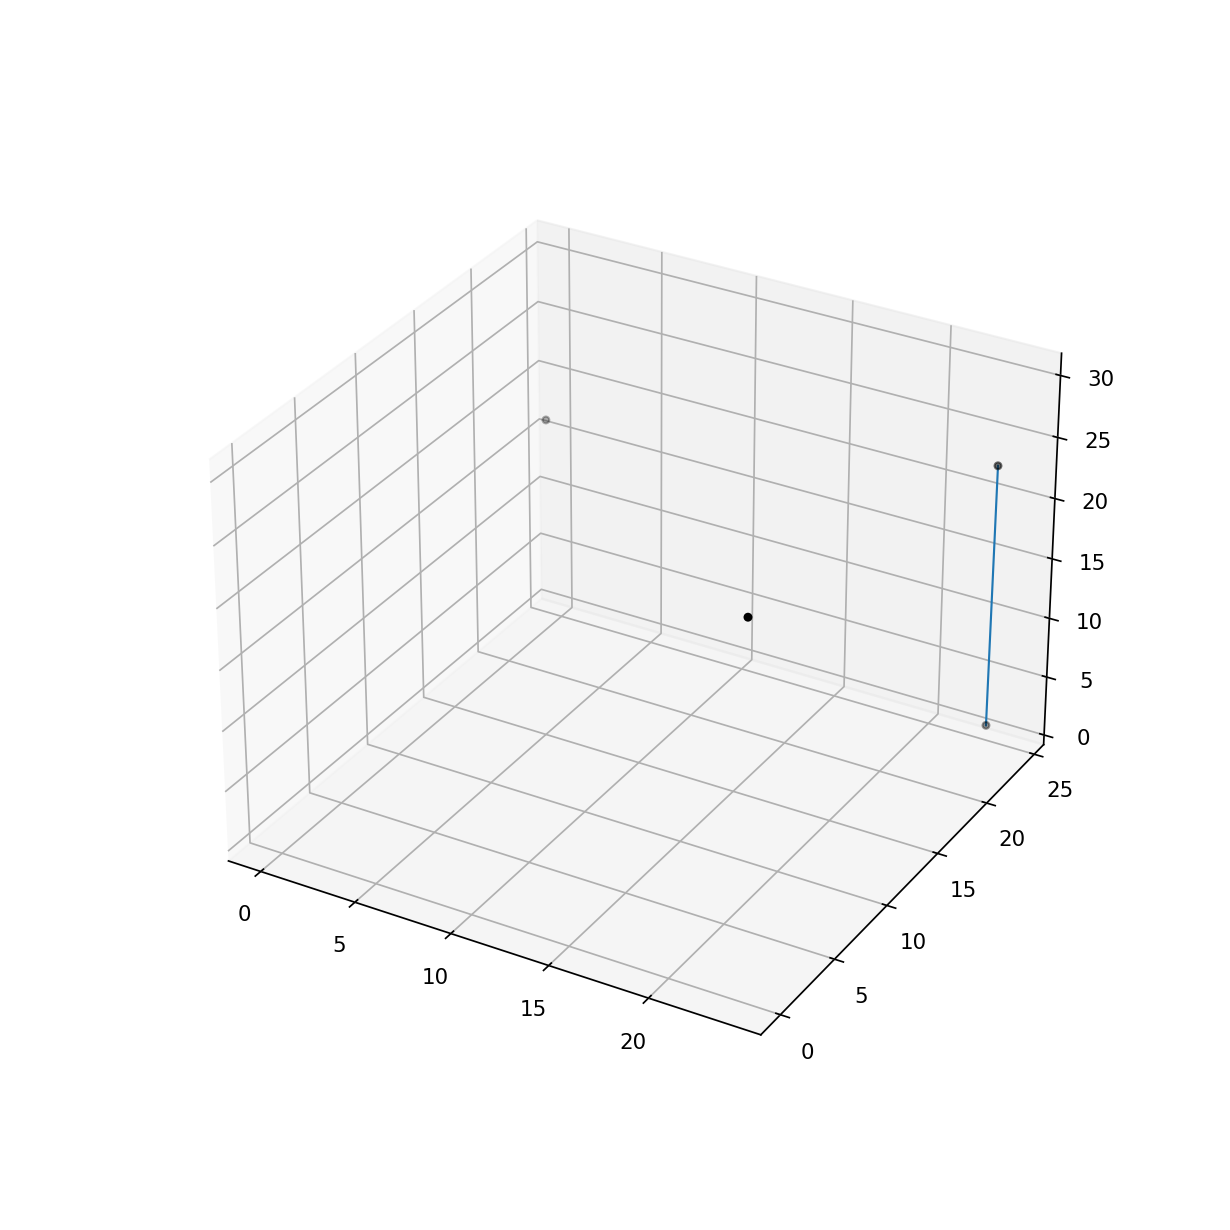

In [267]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

for i in range(len(path)-1):
    

    ax.plot([pos_mat[int(path[i])][0], pos_mat[int(path[i+1])][0]], 
            [pos_mat[int(path[i])][1], pos_mat[int(path[i+1])][1]],
            zs=[pos_mat[int(path[i])][2], pos_mat[int(path[i+1])][2]], linewidth=1)

x_ax = pos_mat[:, 0]
y_ax = pos_mat[:, 1]
z_ax = pos_mat[:, 2]

ax.scatter(x_ax,y_ax,z_ax, s=10, c='black') 

for i in range(len(alldata.loc[alldata['separatrixID'] == 1675])):

    x_sep = alldata.loc[alldata['separatrixID'] == 1675].iloc[i, [0,1,2]].values[0]
    y_sep = alldata.loc[alldata['separatrixID'] == 1675].iloc[i, [0,1,2]].values[1]
    z_sep = alldata.loc[alldata['separatrixID'] == 1675].iloc[i, [0,1,2]].values[2]

    ax.scatter(x_sep,y_sep,z_sep, s=30, c='red')
    
for i in range(len(alldata.loc[alldata['separatrixID'] == 1615])):
    

    x_sep = alldata.loc[alldata['separatrixID'] == 1615].iloc[i, [0,1,2]].values[0]
    y_sep = alldata.loc[alldata['separatrixID'] == 1615].iloc[i, [0,1,2]].values[1]
    z_sep = alldata.loc[alldata['separatrixID'] == 1615].iloc[i, [0,1,2]].values[2]

    ax.scatter(x_sep,y_sep,z_sep, s=20, c='purple')

x = pos_mat_total[:, 0]
y = pos_mat_total[:, 1]
z = pos_mat_total[:, 2]

# ax.scatter(x,y,z, s=1, c='blue') 

# ax.scatter(pos_mat[int(path[0]), 0],pos_mat[int(path[0]), 1],pos_mat[int(path[0]), 2], s=50, c='green')
# ax.scatter(pos_mat[int(path[-1]), 0],pos_mat[int(path[-1]), 1],pos_mat[int(path[-1]), 2], s=50, c='orange')

In [268]:
print(path, '______', path[2], path[3], path[4])
print(all_id_list[int(path[2])], all_id_list[int(path[3])], all_id_list[int(path[4])])

IndexError: list index out of range

In [212]:
sad_max_df.loc[sad_max_df['pointCellId'] == 11473424]

,x,y,z,pointCellId,separatrixID,SepOriginID,SepDestinationID,SepMinValue,isMaxima,isSaddle,xScaled,yScaled,zScaled


In [213]:
sad_max_df.loc[sad_max_df['pointCellId'] == 6979507]

,x,y,z,pointCellId,separatrixID,SepOriginID,SepDestinationID,SepMinValue,isMaxima,isSaddle,xScaled,yScaled,zScaled


In [214]:
sad_max_df.loc[sad_max_df['pointCellId'] == 19591455]

,x,y,z,pointCellId,separatrixID,SepOriginID,SepDestinationID,SepMinValue,isMaxima,isSaddle,xScaled,yScaled,zScaled


In [269]:
# alldata.loc[alldata['separatrixID'] == 1615]

In [270]:
# sep_df = sad_max_df.loc[sad_max_df['separatrixID'] == 1816]
# u = trans_id_pos[str(sep_df.iloc[0, 3])]
# v = trans_id_pos[str(sep_df.iloc[1, 3])]

# print(u, v)
# sep_df

In [271]:
# Lists for saddle point and maximum points
max_list = list(pos_df.loc[pos_df['isMaxima'] == 1, ['pointCellId']].iloc[:,0].values)
saddle_list = list(pos_df.loc[pos_df['isSaddle'] == 1, ['pointCellId']].iloc[:,0].values)

saddle_maxi = saddle_list + max_list
# saddle_maxi = set(saddle_list + saddle_list)
print(len(saddle_maxi), len(set(saddle_maxi)))

12 4


In [272]:
plot_total = np.zeros((len(pos_df),dim))

for i in range(len(pos_df)):
    plot_total[i] = pos_df.iloc[i,[0,1,2]].values

In [273]:
sep_list = list(set(pos_df['separatrixID']))

In [298]:
%store -r interdata

In [294]:
interdata.keys()

dict_keys(['pos_mat', 'node_path', 'path', 'dist_mat'])

In [299]:
dist_mat = interdata['dist_mat']
# zeo_points = interdata['pos_mat'] 
# zeo_node_path = interdata['node_path'] 
# zeo_path = interdata['path']
# pos_zeo = np.array([zeo_points[:,0]*6.9, zeo_points[:,1]*6.9, zeo_points[:,2]*6.83]).transpose()
# zeo_dist = np.ones((len(pos_zeo), len(pos_zeo)))*-1
# for i in range(len(pos_zeo)):
#     for j in range(len(pos_zeo)):
#         if dist_mat[i,j] == -1:
#             pass
#         else:
#             zeo_dist[i,j] = np.sqrt(np.sum(np.power(pos_zeo[i,:] - pos_zeo[j,:], 2)))

In [303]:
sep_dic

%store sep_dic
%store sep_list

Stored 'sep_dic' (dict)
Stored 'sep_list' (list)


In [305]:
sep_dic

{'52': array([[23.7071  ,  0.      , 29.7071  ],
        [23.5     ,  0.218789, 29.7812  ],
        [23.7588  ,  0.241181, 29.6589  ],
        [23.7812  ,  0.5     , 29.7812  ],
        [23.6589  ,  0.758819, 29.7588  ],
        [23.7812  ,  0.781211, 29.5     ],
        [23.7071  ,  1.      , 29.7071  ],
        [23.5     ,  1.21879 , 29.7812  ],
        [23.7588  ,  1.24118 , 29.6589  ],
        [23.7812  ,  1.5     , 29.7812  ],
        [23.6589  ,  1.75882 , 29.7588  ],
        [23.7812  ,  1.78121 , 29.5     ],
        [23.7071  ,  2.      , 29.7071  ],
        [23.5     ,  2.21879 , 29.7812  ],
        [23.7588  ,  2.24118 , 29.6589  ],
        [23.7812  ,  2.5     , 29.7812  ],
        [23.6589  ,  2.75882 , 29.7588  ],
        [23.7812  ,  2.78121 , 29.5     ],
        [23.7071  ,  3.      , 29.7071  ],
        [23.5     ,  3.21879 , 29.7812  ],
        [23.7588  ,  3.24118 , 29.6589  ],
        [23.7812  ,  3.5     , 29.7812  ],
        [23.6589  ,  3.75882 , 29.7588  ],
     

<IPython.core.display.Javascript object>


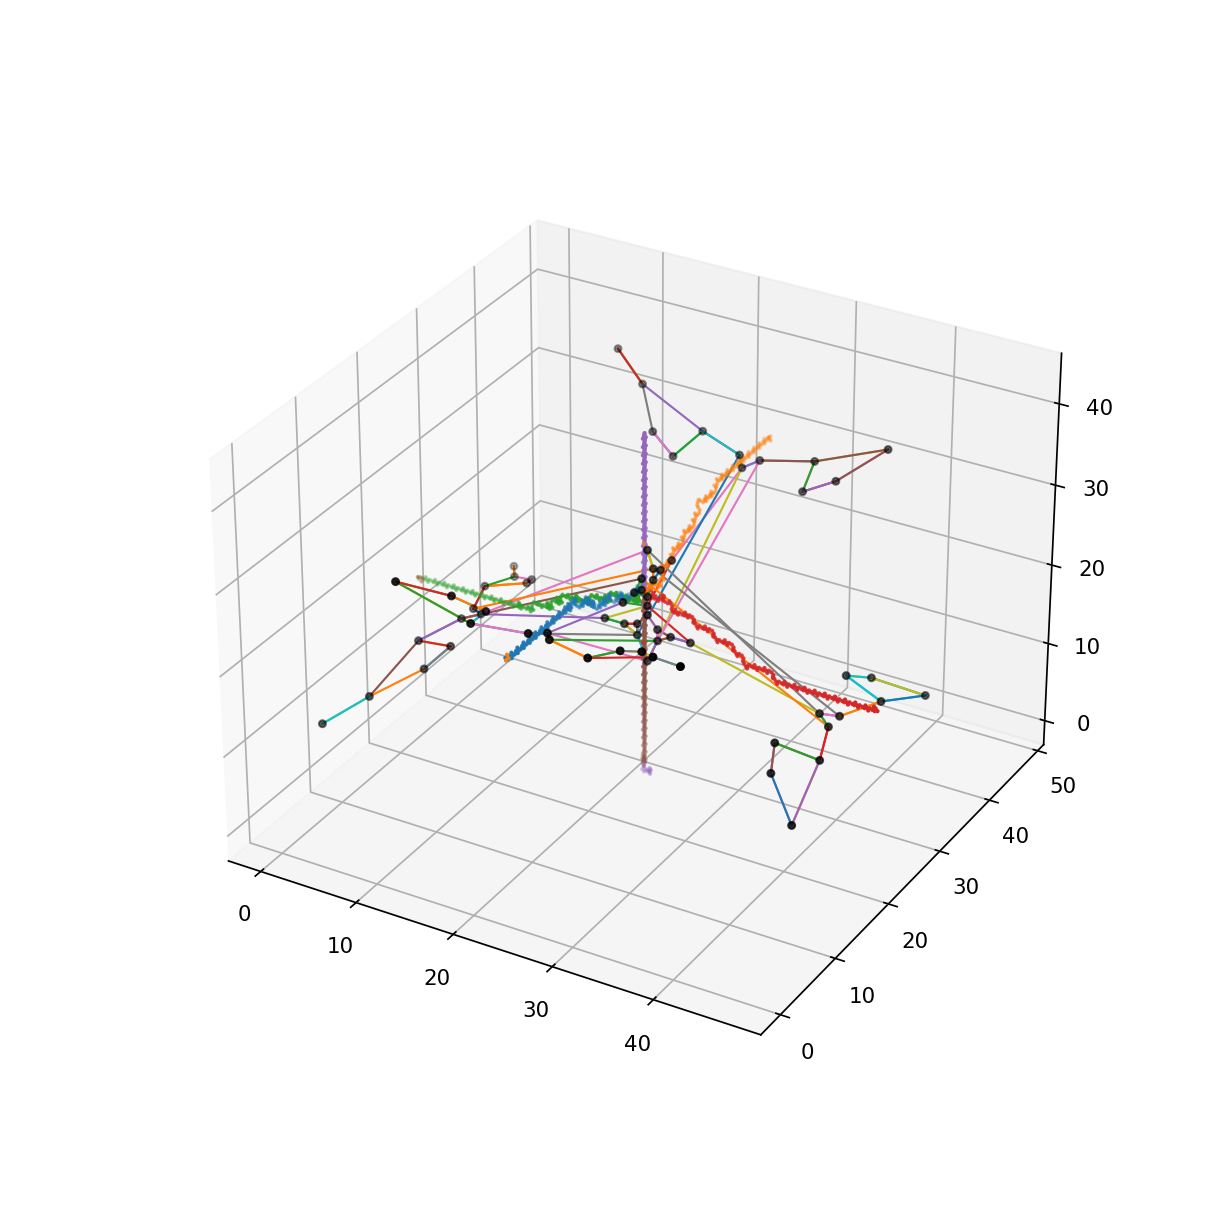

In [302]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

for i in range(len(zeo_dist)):
    for j in range(len(zeo_dist)):
        if dist_mat[i, j] == -1:
            pass
        elif np.sqrt(np.sum(np.power(pos_zeo[i,:] - pos_zeo[j,:], 2))) <= max(dist_mat[i,:]):
            ax.plot([pos_zeo[i,0], pos_zeo[j,0]], 
                    [pos_zeo[i, 1], pos_zeo[j, 1]],
                    zs=[pos_zeo[i, 2], pos_zeo[j, 2]], linewidth=1)


# for i in range(len(zeo_node_path)-1):

#     ax.plot([zeo_points[int(zeo_path[i])][0], zeo_points[int(zeo_path[i+1])][0]], 
#             [zeo_points[int(zeo_path[i])][1], zeo_points[int(zeo_path[i+1])][1]],
#             zs=[zeo_points[int(zeo_path[i])][2], zeo_points[int(zeo_path[i+1])][2]], linewidth=4, color='blue')

x_ax = zeo_points[:,0]*6.9
y_ax = zeo_points[:,1]*6.9
z_ax = zeo_points[:,2]*6.83

ax.scatter(x_ax,y_ax,z_ax, s=10, c='black') 
    

S = len(set(saddle_maxi))
dim = 3

        
sep_dic = {}

for sep in sep_list:
    plot_total = pos_df.loc[pos_df['separatrixID'] == sep, ['x','y','z']].values
    sep_dic[str(sep)] = plot_total
    x_tot = plot_total[:, 0]
    y_tot = plot_total[:, 1]
    z_tot = plot_total[:, 2]

    ax.scatter(x_tot,y_tot,z_tot, s=1)
                      
                      
# for i in range(S):
#     plot_p = pos_df.loc[pos_df['pointCellId'] == list(set(saddle_maxi))[i]].iloc[:,[0,1,2]].values
    
#     x_ax = plot_p[:, 0]
#     y_ax = plot_p[:, 1]
#     z_ax = plot_p[:, 2]

#     ax.scatter(x_ax,y_ax,z_ax, s=30, c='black')
    
    
# for i in range(len(list(nodes))):
#     plot_p = pos_df.loc[pos_df['pointCellId'] == list(nodes)[i]].iloc[:,[0,1,2]].values
    
#     x_ax = plot_p[:, 0]
#     y_ax = plot_p[:, 1]
#     z_ax = plot_p[:, 2]

#     ax.scatter(x_ax,y_ax,z_ax, s=15, c='red')

In [238]:
np.concatenate((np.array([x_ax, y_ax, z_ax]).transpose(), np.array([x_ax, y_ax, z_ax]).transpose())).shape

(3644, 3)

(3644, 3)

<IPython.core.display.Javascript object>


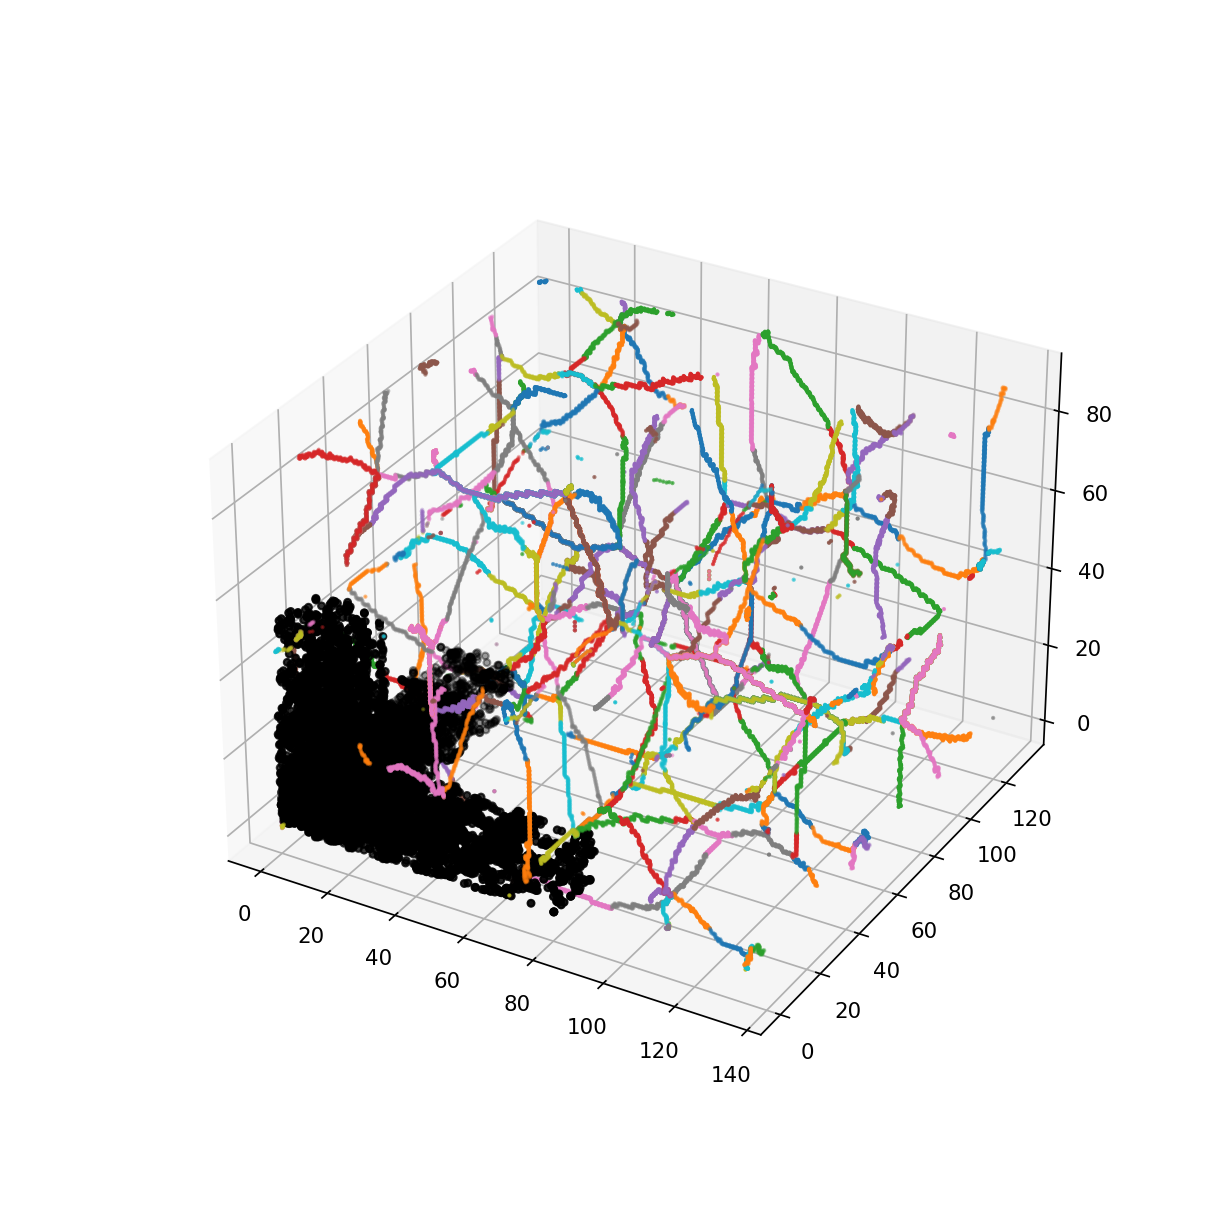

2
3
4
(18220, 3)


In [255]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

x_ax = zeo_points[:,0]
y_ax = zeo_points[:,1]
z_ax = zeo_points[:,2]
temp = zeo_points
for i in range(2,5):
    print(i)
#     ax.scatter(x_ax*i,y_ax,z_ax, s=10, c='black')
    temp = np.concatenate((temp, np.array([x_ax*i, y_ax, z_ax]).transpose()))
    
for i in range(2,5):
#     ax.scatter(x_ax*i,y_ax,z_ax, s=10, c='black')
    temp = np.concatenate((temp, np.array([x_ax, y_ax*i, z_ax]).transpose()))
    
for i in range(2,5):
#     ax.scatter(x_ax*i,y_ax,z_ax, s=10, c='black')
    temp = np.concatenate((temp, np.array([x_ax, y_ax, z_ax*i]).transpose()))
print(temp.shape)    
ax.scatter(temp[:,0],temp[:,1],temp[:,2], s=10, c='black')

for sep in sep_list:
    plot_total = pos_df.loc[pos_df['separatrixID'] == sep, ['x','y','z']].values
    x_tot = plot_total[:, 0]
    y_tot = plot_total[:, 1]
    z_tot = plot_total[:, 2]

    ax.scatter(x_tot,y_tot,z_tot, s=1)

In [253]:
id_list = set()
nodes = set()
for i in range(len(pos_df)):
    id_point = pos_df.iloc[i,3]
    
    if id_point in id_list:
        nodes.add(id_point)
    else:
        id_list.add(id_point)
        

In [53]:
max_list = list(pos_df.loc[pos_df['isMaxima'] == 1, ['pointCellId']].iloc[:,0].values)
saddle_list = list(pos_df.loc[pos_df['isSaddle'] == 1, ['pointCellId']].iloc[:,0].values)

saddle_maxi = saddle_list + max_list

In [55]:
print('All points from FAU files:',len(alldata))
print('All points with positive SepMinValue:', len(pos_df))
print('Number of points that appears at least twice:', len(set(nodes)))
print('Number of points that are saddle or maxima:', len(set(saddle_maxi)))

All points from FAU files: 106720
All points with positive SepMinValue: 33148
Number of points that appears at least twice: 766
Number of points that are saddle or maxima: 112


In [52]:
pos_df.loc[pos_df['pointCellId'] == list(nodes)[0]]

,x,y,z,pointCellId,separatrixID,SepOriginID,SepDestinationID,SepMinValue,isMaxima,isSaddle,xScaled,yScaled,zScaled
264,61.7588,142.659,145.241,34312202,1537,432047,23378240,0.540101,0,0,12.3518,28.5318,29.0482
26662,61.7588,142.659,145.241,34312202,1661,17643280,23378240,3.325490,0,0,12.3518,28.5318,29.0482
63478,61.7588,142.659,145.241,34312202,1814,35702318,23378240,0.555488,0,0,12.3518,28.5318,29.0482
